In [1]:

import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import mean_absolute_error


In [2]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=CAD&limit=500')
# res = requests.get(endpoint + '?fsym=ETH&tsym=CAD&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

In [3]:
hist.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)

In [4]:
hist.head(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2022-03-31,59474.60,56611.27,58671.62,66.42,3851872.00,56947.49
2022-04-01,58296.83,55363.48,56947.49,60.92,3456242.06,57807.28
2022-04-02,58948.47,57136.84,57807.28,31.95,1853130.03,57285.92
2022-04-03,59484.62,56928.96,57285.92,118.76,6899696.76,58149.66
2022-04-04,58465.16,56525.94,58149.66,46.76,2694573.79,58211.09


In [5]:
hist.tail(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2023-08-09,40370.42,39422.08,39940.30,30.390,1208852.04,39701.91
2023-08-10,39755.93,39380.19,39701.91,27.480,1087070.23,39530.15
2023-08-11,39561.64,39270.33,39530.15,25.630,1012078.74,39469.18
2023-08-12,39892.28,39360.18,39469.18,13.090,516853.85,39443.27
2023-08-13,39653.58,39366.30,39443.27,5.562,219563.37,39406.27


In [6]:
hist.shape

(501, 6)

In [7]:
hist.describe

<bound method NDFrame.describe of                 high       low      open  volumefrom    volumeto     close
time                                                                      
2022-03-31  59474.60  56611.27  58671.62      66.420  3851872.00  56947.49
2022-04-01  58296.83  55363.48  56947.49      60.920  3456242.06  57807.28
2022-04-02  58948.47  57136.84  57807.28      31.950  1853130.03  57285.92
2022-04-03  59484.62  56928.96  57285.92     118.760  6899696.76  58149.66
2022-04-04  58465.16  56525.94  58149.66      46.760  2694573.79  58211.09
...              ...       ...       ...         ...         ...       ...
2023-08-09  40370.42  39422.08  39940.30      30.390  1208852.04  39701.91
2023-08-10  39755.93  39380.19  39701.91      27.480  1087070.23  39530.15
2023-08-11  39561.64  39270.33  39530.15      25.630  1012078.74  39469.18
2023-08-12  39892.28  39360.18  39469.18      13.090   516853.85  39443.27
2023-08-13  39653.58  39366.30  39443.27       5.562   219563.37  

In [8]:
hist.info

<bound method DataFrame.info of                 high       low      open  volumefrom    volumeto     close
time                                                                      
2022-03-31  59474.60  56611.27  58671.62      66.420  3851872.00  56947.49
2022-04-01  58296.83  55363.48  56947.49      60.920  3456242.06  57807.28
2022-04-02  58948.47  57136.84  57807.28      31.950  1853130.03  57285.92
2022-04-03  59484.62  56928.96  57285.92     118.760  6899696.76  58149.66
2022-04-04  58465.16  56525.94  58149.66      46.760  2694573.79  58211.09
...              ...       ...       ...         ...         ...       ...
2023-08-09  40370.42  39422.08  39940.30      30.390  1208852.04  39701.91
2023-08-10  39755.93  39380.19  39701.91      27.480  1087070.23  39530.15
2023-08-11  39561.64  39270.33  39530.15      25.630  1012078.74  39469.18
2023-08-12  39892.28  39360.18  39469.18      13.090   516853.85  39443.27
2023-08-13  39653.58  39366.30  39443.27       5.562   219563.37  39

In [9]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [10]:
train, test = train_test_split(hist, test_size=0.2)

In [11]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

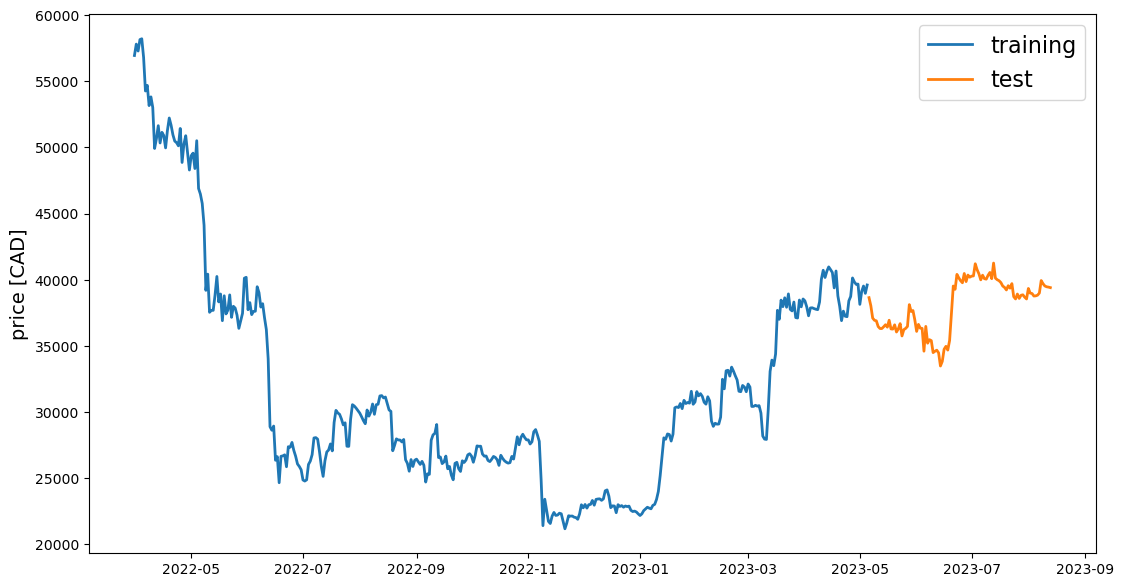

In [12]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [13]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [14]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [15]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [16]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model


In [17]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [18]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [19]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
13/13 [==============================] - 10s 169ms/step - loss: 0.0053 - val_loss: 0.0026
Epoch 2/20
13/13 [==============================] - 0s 25ms/step - loss: 0.0034 - val_loss: 7.5423e-04
Epoch 3/20
13/13 [==============================] - 0s 25ms/step - loss: 0.0030 - val_loss: 9.4693e-04
Epoch 4/20
13/13 [==============================] - 0s 24ms/step - loss: 0.0032 - val_loss: 5.9156e-04
Epoch 5/20
13/13 [==============================] - 0s 24ms/step - loss: 0.0024 - val_loss: 5.1652e-04
Epoch 6/20
13/13 [==============================] - 0s 25ms/step - loss: 0.0022 - val_loss: 5.0124e-04
Epoch 7/20
13/13 [==============================] - 0s 26ms/step - loss: 0.0022 - val_loss: 4.6646e-04
Epoch 8/20
13/13 [==============================] - 0s 29ms/step - loss: 0.0021 - val_loss: 4.3499e-04
Epoch 9/20
13/13 [==============================] - 0s 25ms/step - loss: 0.0019 - val_loss: 4.6392e-04
Epoch 10/20
13/13 [==============================] - 0s 27ms/step - loss: 0

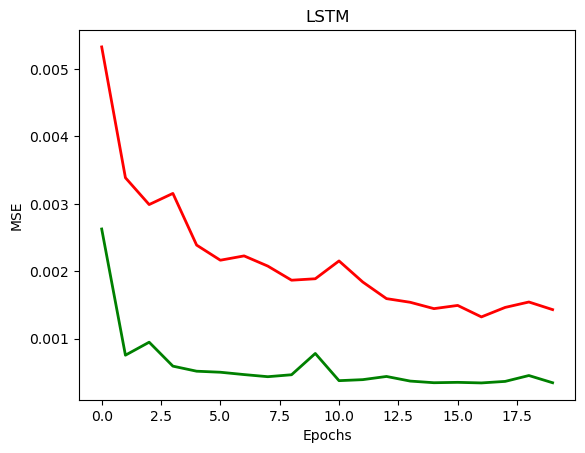

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [21]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

3/3 [==============================] - 2s 10ms/step


0.011420793385570576

In [22]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE

0.00034522083018874726

In [23]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.7675180384391522

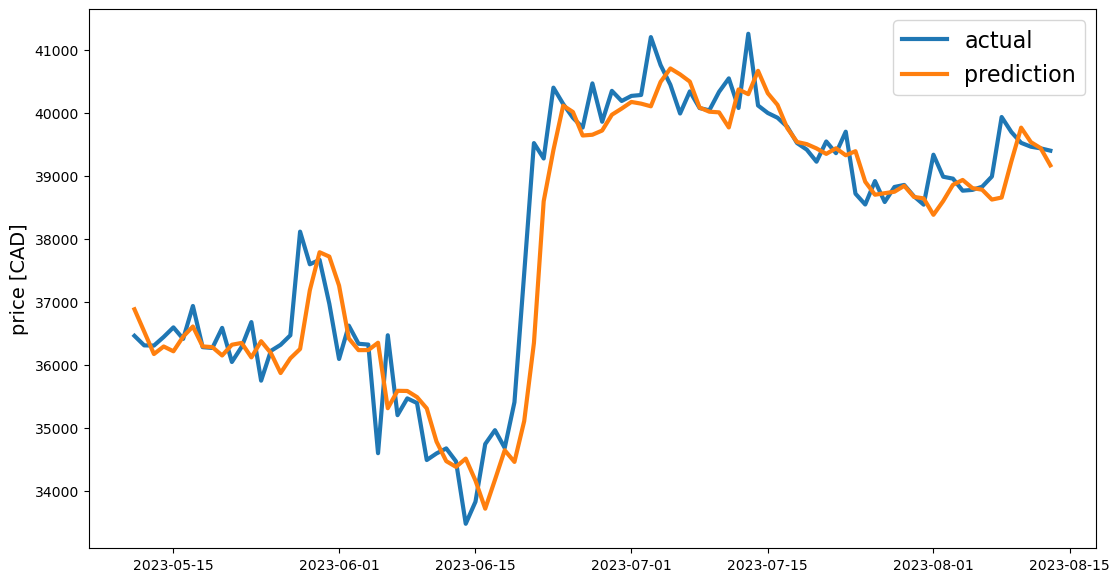

In [24]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [25]:
# Step 4: Predict future prices
# last_n_days = hist[-window_len:].values.reshape((1, window_len, 6))
future_prices = []
num_predictions = 30 # number of future time steps to predict
for i in range(num_predictions):
    last_n_days = hist.iloc[i:i+window_len].values.reshape((1, window_len, 6))
    prediction = model.predict(last_n_days).squeeze()
    future_prices.append(prediction)

1/1 [==============================] - 0s 86ms/step


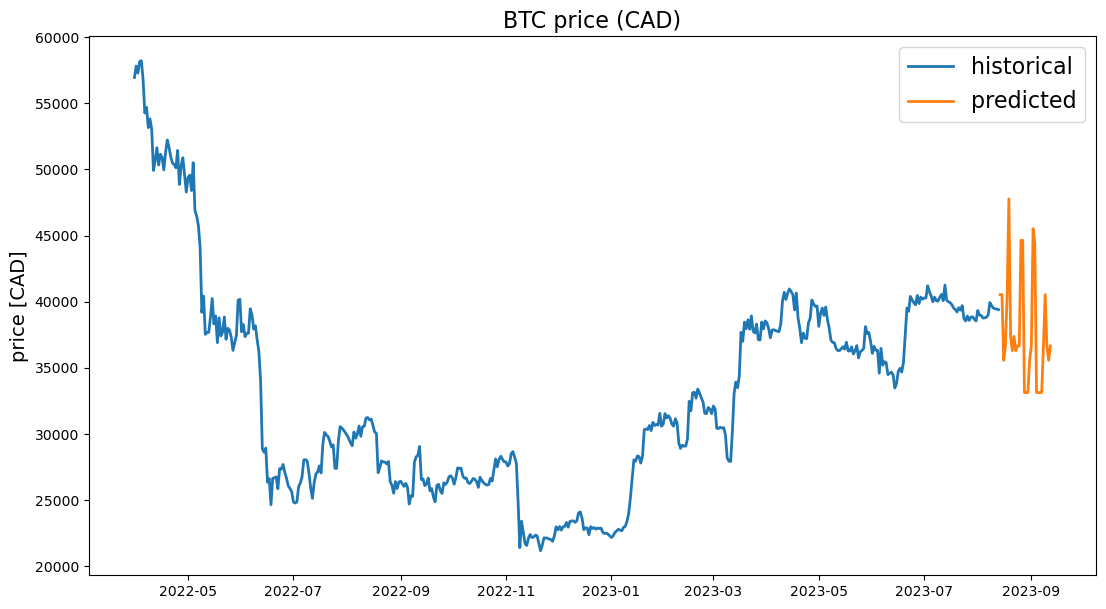

In [26]:
# Step 5: Plot predicted future prices
future_index = pd.date_range(start=hist.index[-1], periods=num_predictions+1, freq='D')[1:]
future_prices = test[target_col].values[-1] * (np.array(future_prices) + 1)
future_prices = pd.Series(index=future_index, data=future_prices)
line_plot(hist[target_col], future_prices, 'historical', 'predicted', title='BTC price (CAD)')

In [ ]:
import tkinter as tk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import pandas as pd
import numpy as np

# Define the GUI class
class CryptoPricePredictionGUI(tk.Tk):
    def __init__(self):
        tk.Tk.__init__(self)
        self.title("Cryptocurrency Price Prediction")

        # Create GUI widgets
        self.label_currency = tk.Label(self, text="Currency:")
        self.label_currency.pack()

        # Replace 'currencies' with a list of available cryptocurrencies
        currencies = ["BTC"]  # Example list of currencies
        self.currency_var = tk.StringVar(self)
        self.currency_var.set(currencies[0])
        self.currency_menu = tk.OptionMenu(self, self.currency_var, *currencies)
        self.currency_menu.pack()

        self.label_period = tk.Label(self, text="Time Period (in days):")
        self.label_period.pack()

        self.entry_period = tk.Entry(self)
        self.entry_period.pack()

        self.button_classify = tk.Button(self, text="Classify", command=self.classify)
        self.button_classify.pack()

        self.figure = plt.Figure(figsize=(6, 4), dpi=100)
        self.ax = self.figure.add_subplot(111)
        self.canvas = FigureCanvasTkAgg(self.figure, master=self)
        self.canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)

    def classify(self):
        currency = self.currency_var.get()
        period = int(self.entry_period.get())

        # Call your classification function with the given currency and time period
        # Replace the following line with your actual classification code
        # predicted_prices, future_prices = self.predict_prices(currency, period)

        # Step 4: Predict future prices
        window_len = 30  # Window length for input data
        future_prices = []
        num_predictions = period  # number of future time steps to predict

        for i in range(num_predictions):
            last_n_days = hist.iloc[i:i + window_len].values.reshape((1, window_len, 6))
            prediction = model.predict(last_n_days).squeeze()
            future_prices.append(prediction)

        # Step 5: Plot predicted future prices
        future_index = pd.date_range(start=hist.index[-1], periods=num_predictions + 1, freq='D')[1:]
        future_prices = test[target_col].values[-1] * (np.array(future_prices) + 1)
        future_prices = pd.Series(index=future_index, data=future_prices)

        self.ax.clear()
        self.ax.plot_date(hist.index, hist[target_col], label='Historical', linestyle='-', marker=None)
        self.ax.plot_date(future_prices.index, future_prices, label='Predicted', linestyle='-', marker=None)
        self.ax.set_xlabel('Date')
        self.ax.set_ylabel('Price')
        self.ax.set_title(f'{currency} Price Prediction')
        self.ax.legend()

        self.canvas.draw()
        

    def predict_prices(self, currency, period):
        # Replace this function with your actual prediction and classification logic
        # Return a list of predicted prices and future prices for the given currency and time period
        # You can use any prediction model or method here

        # Example code for generating future prices using a trained model
        window_len = 30  # Window length for input data
        future_prices = []

        # Replace this loop with your actual prediction code
        for i in range(period):
            last_n_days = hist.iloc[i:i + window_len].values.reshape((1, window_len, 6))
            prediction = model.predict(last_n_days).squeeze()
            future_prices.append(prediction)

        predicted_prices = [100 + i * 10 + np.random.randint(-5, 5) for i in range(period)]

        return predicted_prices, future_prices


# Create an instance of the GUI
app = CryptoPricePredictionGUI()

# Run the GUI main loop
app.mainloop()


1/1 [==============================] - 0s 60ms/step


C:\Users\hp\AppData\Local\Temp\ipykernel_1796\929523938.py:62: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  self.ax.plot_date(hist.index, hist[target_col], label='Historical', linestyle='-', marker=None)
C:\Users\hp\AppData\Local\Temp\ipykernel_1796\929523938.py:63: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  self.ax.plot_date(future_prices.index, future_prices, label='Predicted', linestyle='-', marker=None)
